from google.colab import drive
drive.mount('/content/gdrive')

## install necessary package

! pip install jenkspy

## Imports

In [1]:
# %matplotlib notebook

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from xgboost import XGBRegressor

import os
import pickle
import wordcloud as wc
import scipy.sparse as sparse
import xgboost as xgb
import random
import jenkspy
import statsmodels.tools.tools as stattools
from itertools import combinations

import sklearn
from sklearn import tree
from sklearn.model_selection import KFold,train_test_split
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction import DictVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [2]:
Dataset_path = "./DataSets/"

# EDA

## Movies_metadata

In [7]:
MoviesInfo = pd.read_csv(Dataset_path+"MoviesInfo.csv")
MoviesInfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41896 entries, 0 to 41895
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   movieId                41896 non-null  int64  
 1   genres                 41896 non-null  object 
 2   imdb_title_id          41896 non-null  object 
 3   title                  41896 non-null  object 
 4   year                   41896 non-null  int64  
 5   duration               41896 non-null  int64  
 6   country                41890 non-null  object 
 7   language               41648 non-null  object 
 8   director               41886 non-null  object 
 9   budget                 15453 non-null  object 
 10  usa_gross_income       13291 non-null  object 
 11  worlwide_gross_income  19887 non-null  object 
 12  metascore              11596 non-null  float64
 13  reviews_from_users     40728 non-null  float64
 14  reviews_from_critics   40120 non-null  float64
 15  me

In [8]:
MoviesInfo.isna().sum()

movieId                      0
genres                       0
imdb_title_id                0
title                        0
year                         0
duration                     0
country                      6
language                   248
director                    10
budget                   26443
usa_gross_income         28605
worlwide_gross_income    22009
metascore                30300
reviews_from_users        1168
reviews_from_critics      1776
mean_vote                    0
total_votes                  0
dtype: int64

In [9]:
Movies_metadata = pd.read_csv(Dataset_path+"Movies_metadata.csv")
Movies_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39470 entries, 0 to 39469
Data columns (total 52 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   budget                 39470 non-null  float64
 1   usa_gross_income       39470 non-null  float64
 2   worlwide_gross_income  39470 non-null  float64
 3   metascore              39470 non-null  float64
 4   reviews_from_users     39470 non-null  float64
 5   reviews_from_critics   39470 non-null  float64
 6   director_r             39470 non-null  float64
 7   year                   39470 non-null  float64
 8   duration               39470 non-null  float64
 9   country                39470 non-null  object 
 10  title                  39470 non-null  object 
 11  total_votes            39470 non-null  float64
 12  mean_vote              39470 non-null  float64
 13  language               39470 non-null  object 
 14  imdb_title_id          39470 non-null  object 
 15  ge

In [10]:
Movies_metadata.isna().sum()

budget                   0
usa_gross_income         0
worlwide_gross_income    0
metascore                0
reviews_from_users       0
reviews_from_critics     0
director_r               0
year                     0
duration                 0
country                  0
title                    0
total_votes              0
mean_vote                0
language                 0
imdb_title_id            0
genres                   0
movieId                  0
EU                       0
AS                       0
NA                       0
AF                       0
AN                       0
SA                       0
OC                       0
idk                      0
English                  0
French                   0
Italian                  0
German                   0
Spanish                  0
Russian                  0
Other                    0
Comedy                   0
Romance                  0
Drama                    0
Adventure                0
Children                 0
A

<AxesSubplot:>

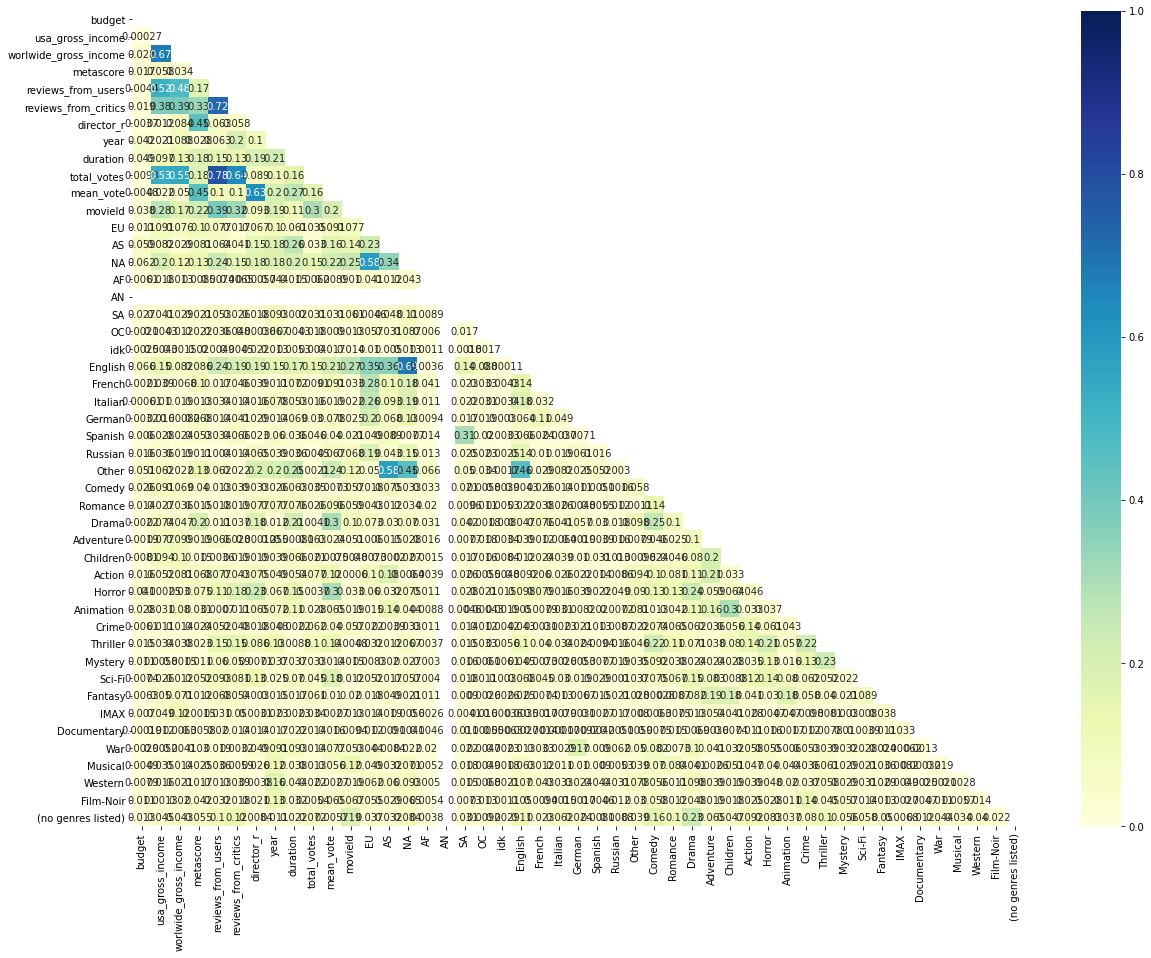

In [15]:
corr = Movies_metadata.corr().abs()

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)

plt.subplots(figsize=(20,15))

# using the upper triangle matrix as mask 
sns.heatmap(corr, annot=True, cmap="YlGnBu", fmt='.2g', vmin=0, vmax=1, mask=matrix)

In [12]:
# MoviesInfo.dropna(inplace=True)
MoviesInfo.year.dropna(inplace=True)

MoviesInfo.year = MoviesInfo.year.astype('int64')

x = MoviesInfo.groupby((MoviesInfo.year//10)*10).count()['imdb_title_id']

x

year
1900        1
1910      101
1920      379
1930     1596
1940     1790
1950     2408
1960     2762
1970     3564
1980     3776
1990     4893
2000     8736
2010    11889
2020        1
Name: imdb_title_id, dtype: int64

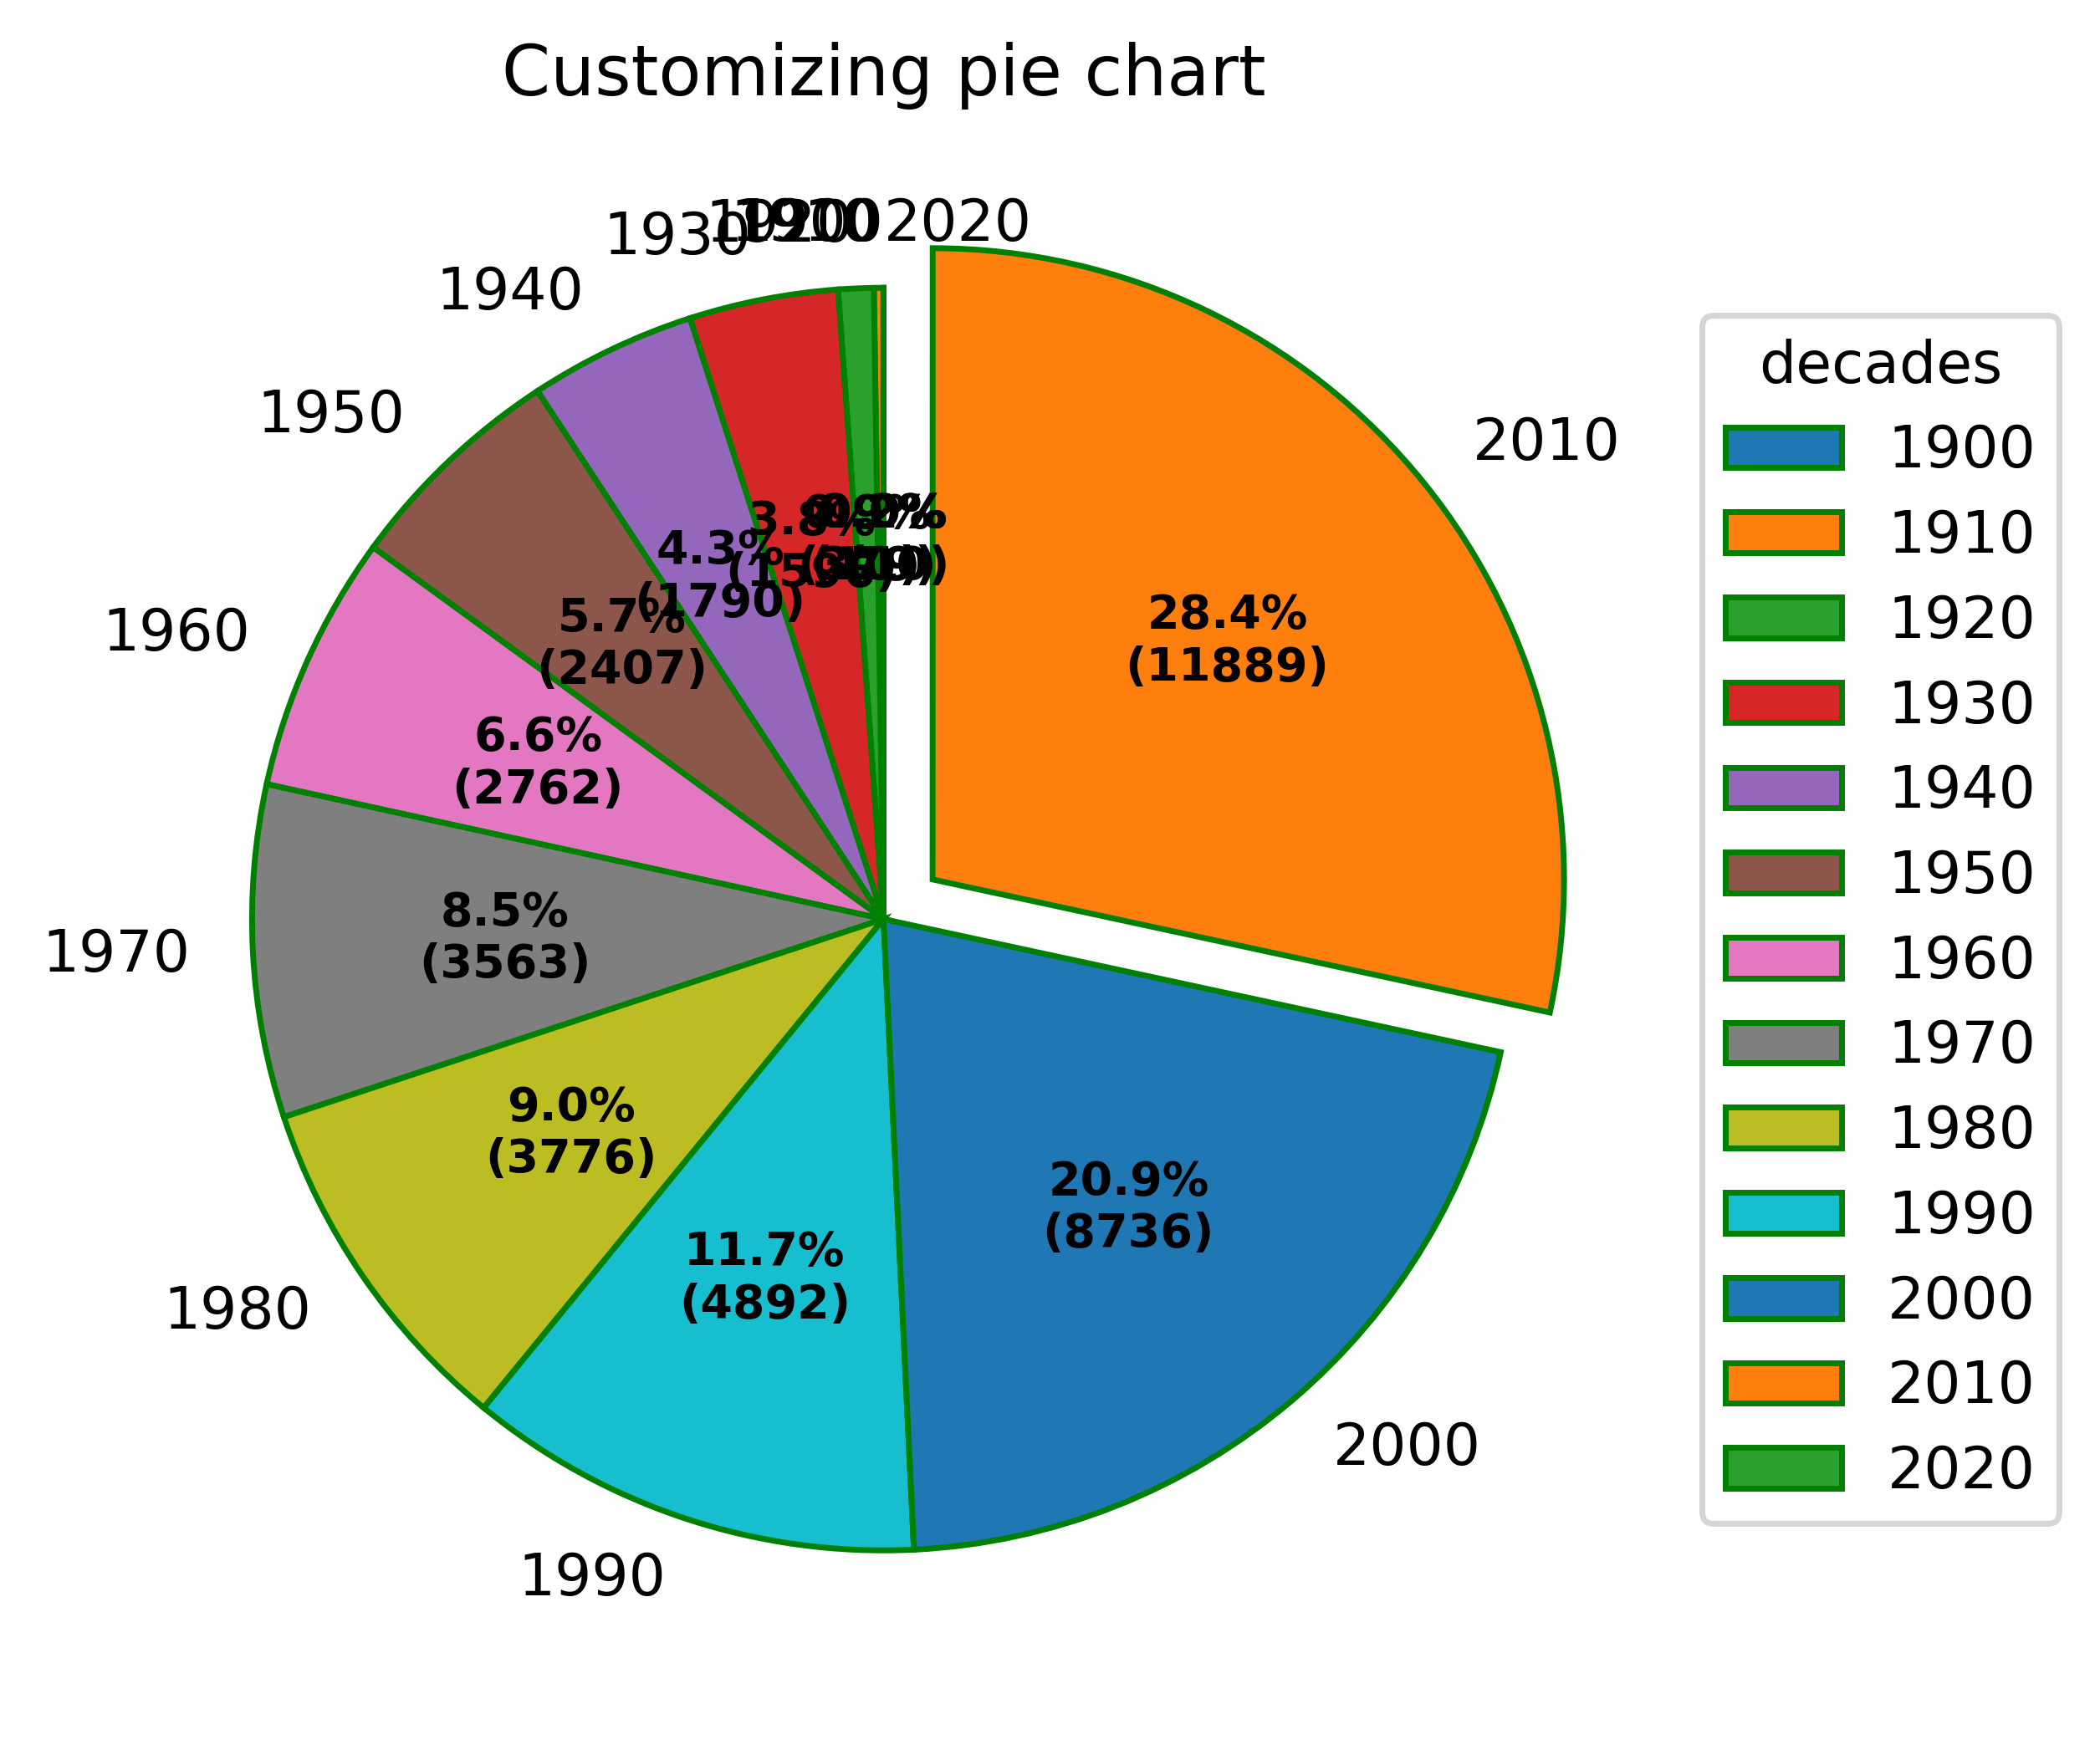

In [13]:
explode = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0)

def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

fig, ax = plt.subplots(figsize =(8,5), dpi=500)

wedges, texts, autotexts = ax.pie(x,
                                  autopct = lambda pct: func(pct, x),
                                  explode = explode,
                                  labels = x.index,
#                                   shadow = True,
                                  startangle = 90,
                                  wedgeprops = { 'linewidth' : 1, 'edgecolor' : "green" }
                                  # textprops = dict(color ="magenta")
                                 )


ax.legend(wedges, x.index,
          title ="decades",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))

plt.setp(autotexts, size = 8, weight ="bold")
ax.set_title("Customizing pie chart")


plt.show()

In [42]:
all_genres = []

for item in Movies_metadata['genres']:
    for subitem in item.split('|'):
        if (subitem not in all_genres):
            all_genres.append( subitem )
print( all_genres )

['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'Mystery', 'Sci-Fi', 'IMAX', 'Documentary', 'War', 'Musical', 'Western', 'Film-Noir', '(no genres listed)']


In [43]:
for i in all_genres:
    Movies_metadata[i] = False

for index, row in Movies_metadata.iterrows():
#     print( index, row['imdb_title_id'], row['genres'])
    for subitem in row['genres'].split('|'):
        Movies_metadata.loc[index, subitem] = True

Adventure :  3244
Animation :  1107
Children :  1648
Comedy :  13029
Fantasy :  1910
Romance :  6515
Drama :  20509
Action :  5921
Crime :  4391
Thriller :  7095
Horror :  4632
Mystery :  2311
Sci-Fi :  2586
IMAX :  167
Documentary :  104
War :  1487
Musical :  889
Western :  1143
Film-Noir :  352
(no genres listed) :  2146


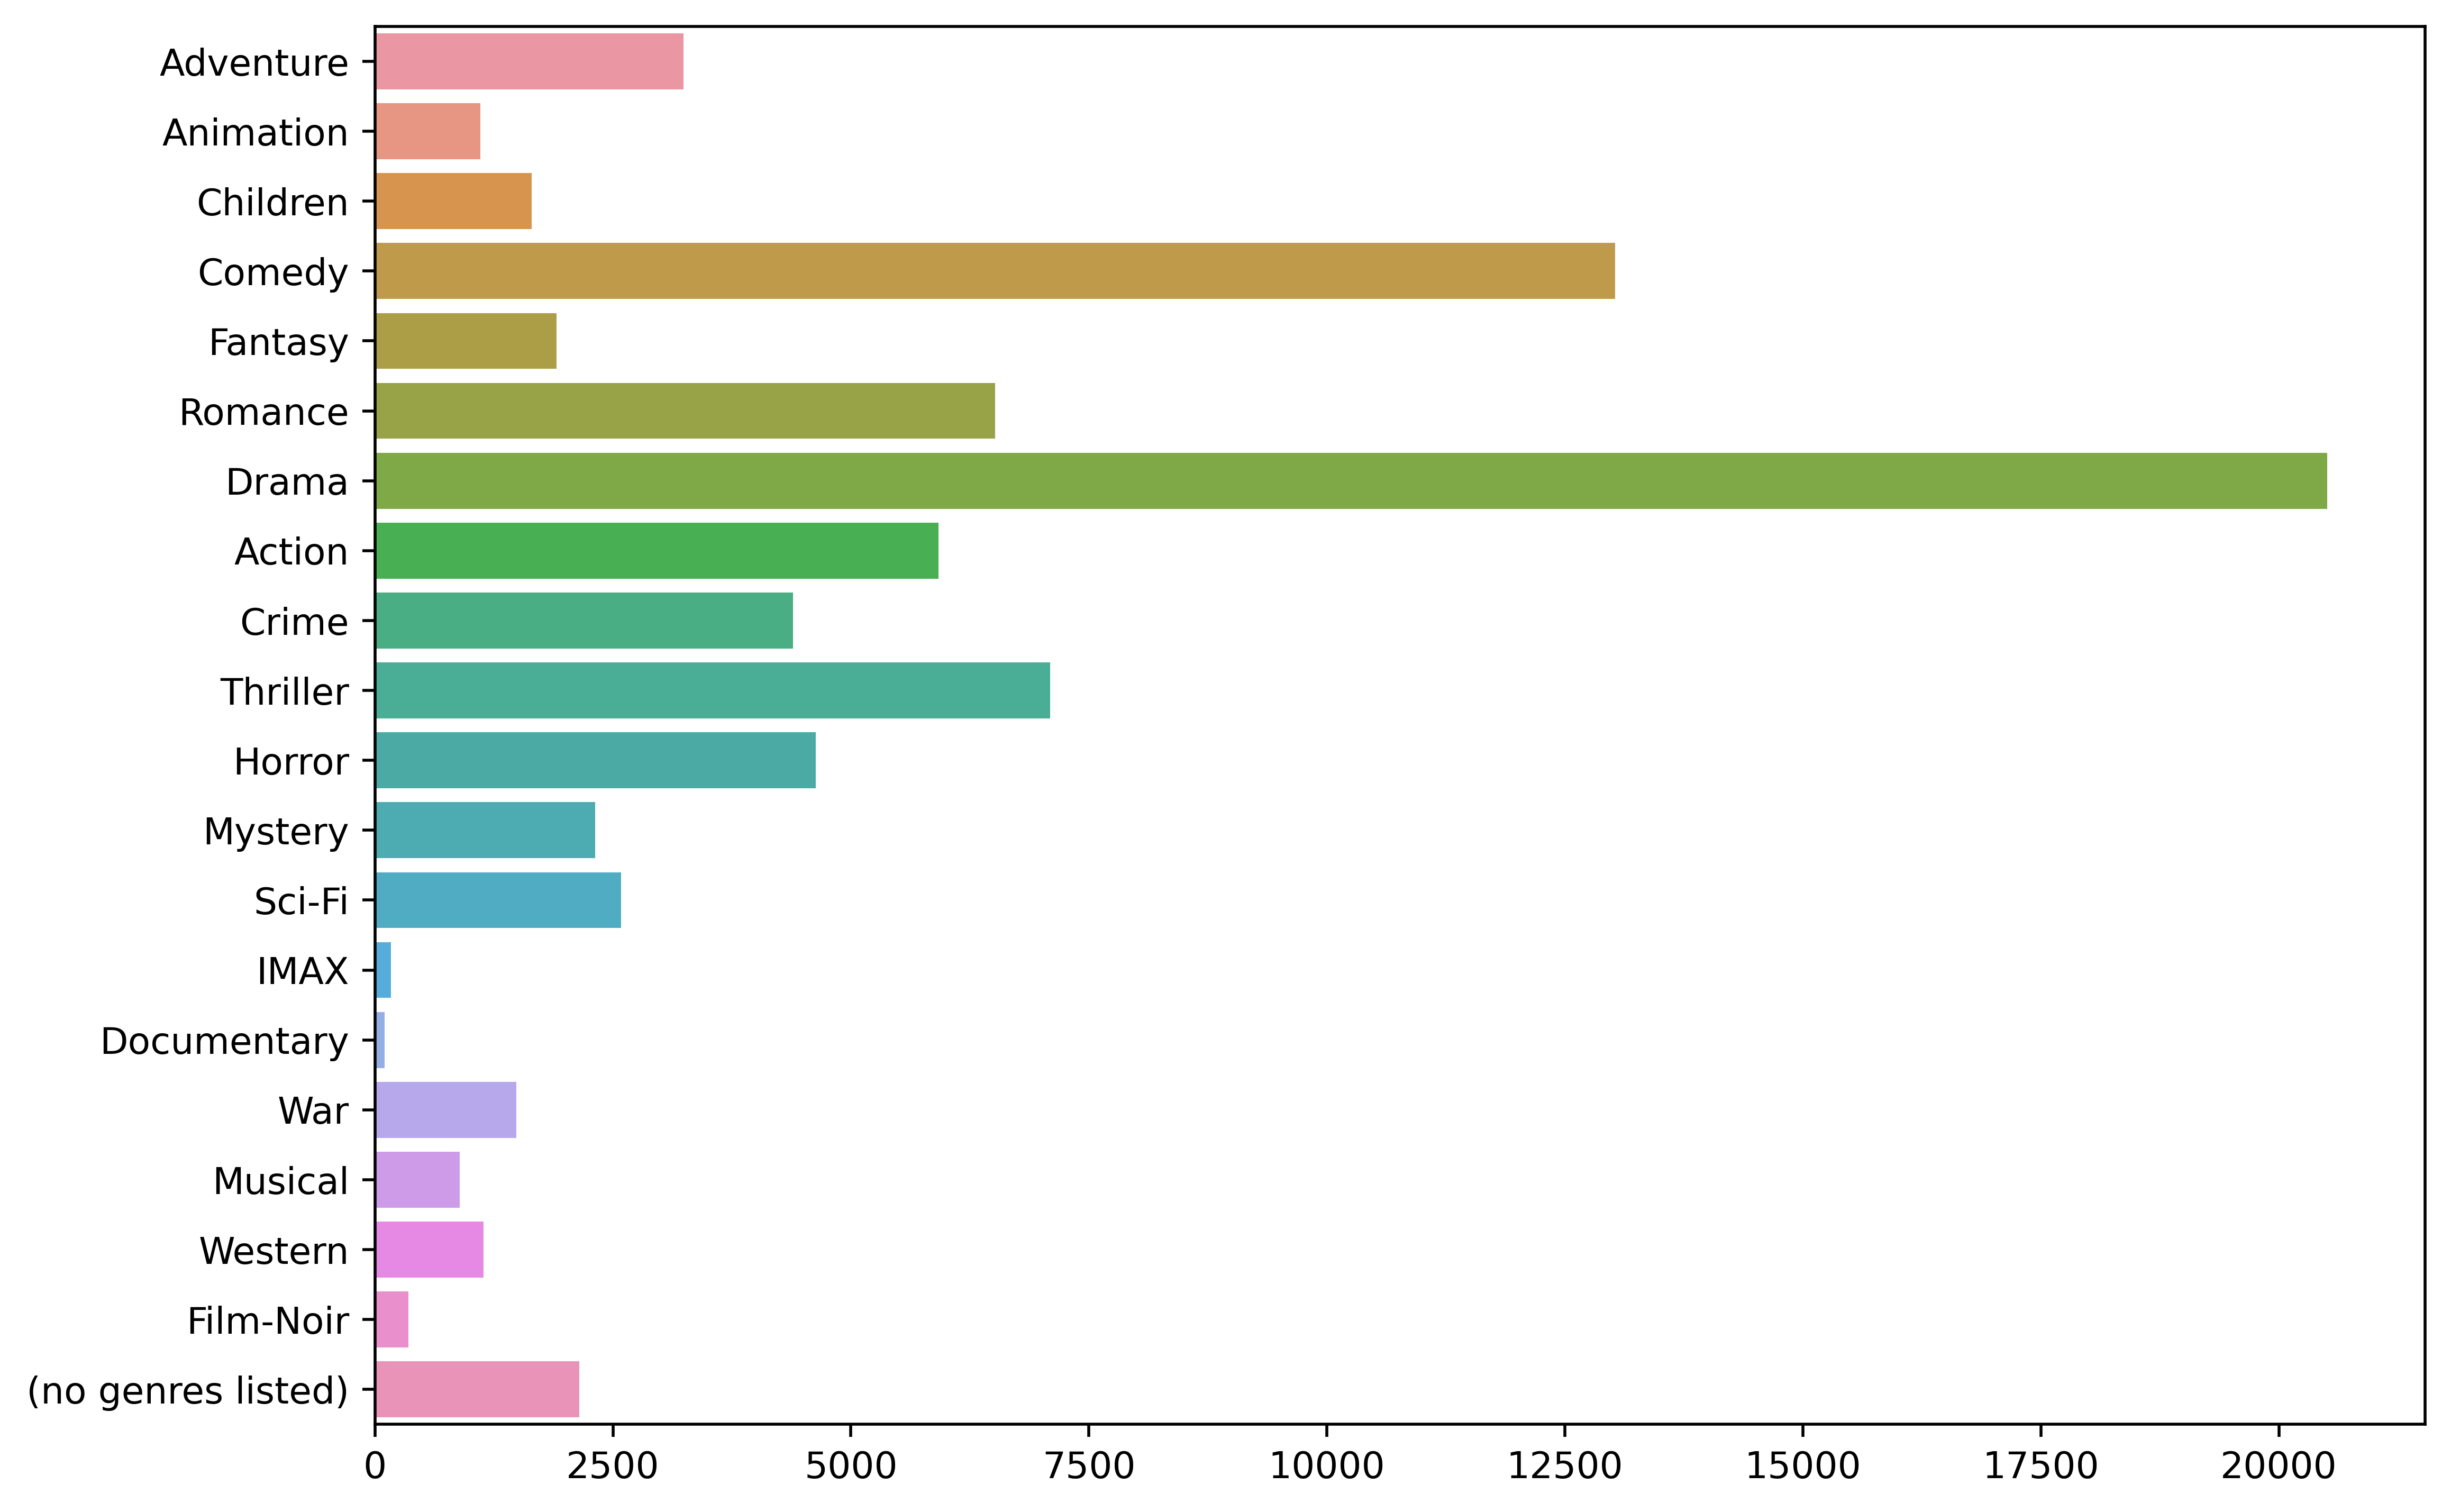

In [44]:
freq = {}

for item in Movies_metadata['genres']:
    for subitem in item.split('|'):
        if (subitem in freq):
            freq[subitem] += 1
        else:
            freq[subitem] = 1

for key, value in freq.items():
    print ("% s : % d"%(key, value))
    
plt.subplots(figsize =(10, 7), dpi=500)
# plt.barh(*zip(*freq.items()))
sns.barplot(y=list(freq.keys()), x=list(freq.values()), orient='h')

In [45]:
l = Movies_metadata.groupby((Movies_metadata.year//10)*10).sum()[ all_genres ]
l.head()

Adventure  Animation  Children  Comedy  Fantasy  Romance  Drama  Action  \
year                                                                            
1900        0.0        0.0       0.0     0.0      0.0      0.0    1.0     1.0   
1910       11.0        0.0       3.0    22.0     11.0     16.0   67.0     5.0   
1920       32.0        1.0       2.0    99.0     17.0    126.0  248.0    19.0   
1930      122.0        6.0      22.0   564.0     37.0    536.0  833.0    81.0   
1940      128.0       14.0      46.0   561.0     63.0    468.0  887.0   111.0   

      Crime  Thriller  Horror  Mystery  Sci-Fi  IMAX  Documentary    War  \
year                                                                       
1900    1.0       0.0     0.0      0.0     0.0   0.0          0.0    0.0   
1910    7.0       2.0     6.0      3.0     1.0   0.0          0.0    8.0   
1920   22.0       9.0    19.0     13.0     8.0   0.0          0.0   20.0   
1930  210.0      93.0    60.0    141.0    31.0   0.0          2.0   65.0   
1940  260.0     203.0    80.0    217.0    24.0   0.0          3.0  163.0   

      Musical  Western  Film-Noir  (no genres listed)  
year                                                   
1900      0.0      0.0        0.0                 0.0  
1910      0.0      6.0        0.0                11.0  
1920     10.0     14.0        2.0                28.0  
1930    114.0     80.0       13.0                97.0  
1940    125.0    110.0      151.0                89.0

In [46]:
state_pcts = l.groupby(level=0).apply(lambda x: 100 * x / float(x.sum(axis=1)))
state_pcts.head()

Adventure  Animation  Children     Comedy   Fantasy    Romance  \
year                                                                   
1900   0.000000   0.000000  0.000000   0.000000  0.000000   0.000000   
1910   6.145251   0.000000  1.675978  12.290503  6.145251   8.938547   
1920   4.644412   0.145138  0.290276  14.368650  2.467344  18.287373   
1930   3.926617   0.193112  0.708079  18.152559  1.190859  17.251368   
1940   3.456657   0.378072  1.242236  15.149878  1.701323  12.638401   

          Drama     Action      Crime  Thriller    Horror   Mystery    Sci-Fi  \
year                                                                            
1900  33.333333  33.333333  33.333333  0.000000  0.000000  0.000000  0.000000   
1910  37.430168   2.793296   3.910615  1.117318  3.351955  1.675978  0.558659   
1920  35.994194   2.757620   3.193033  1.306241  2.757620  1.886792  1.161103   
1930  26.810428   2.607016   6.758931  2.993241  1.931123  4.538140  0.997747   
1940  23.953551   2.997570   7.021334  5.482042  2.160410  5.860113  0.648123   

      IMAX  Documentary       War   Musical   Western  Film-Noir  \
year                                                               
1900   0.0     0.000000  0.000000  0.000000  0.000000   0.000000   
1910   0.0     0.000000  4.469274  0.000000  3.351955   0.000000   
1920   0.0     0.000000  2.902758  1.451379  2.031930   0.290276   
1930   0.0     0.064371  2.092050  3.669134  2.574831   0.418410   
1940   0.0     0.081015  4.401836  3.375641  2.970564   4.077775   

      (no genres listed)  
year                      
1900            0.000000  
1910            6.145251  
1920            4.063861  
1930            3.121983  
1940            2.403457

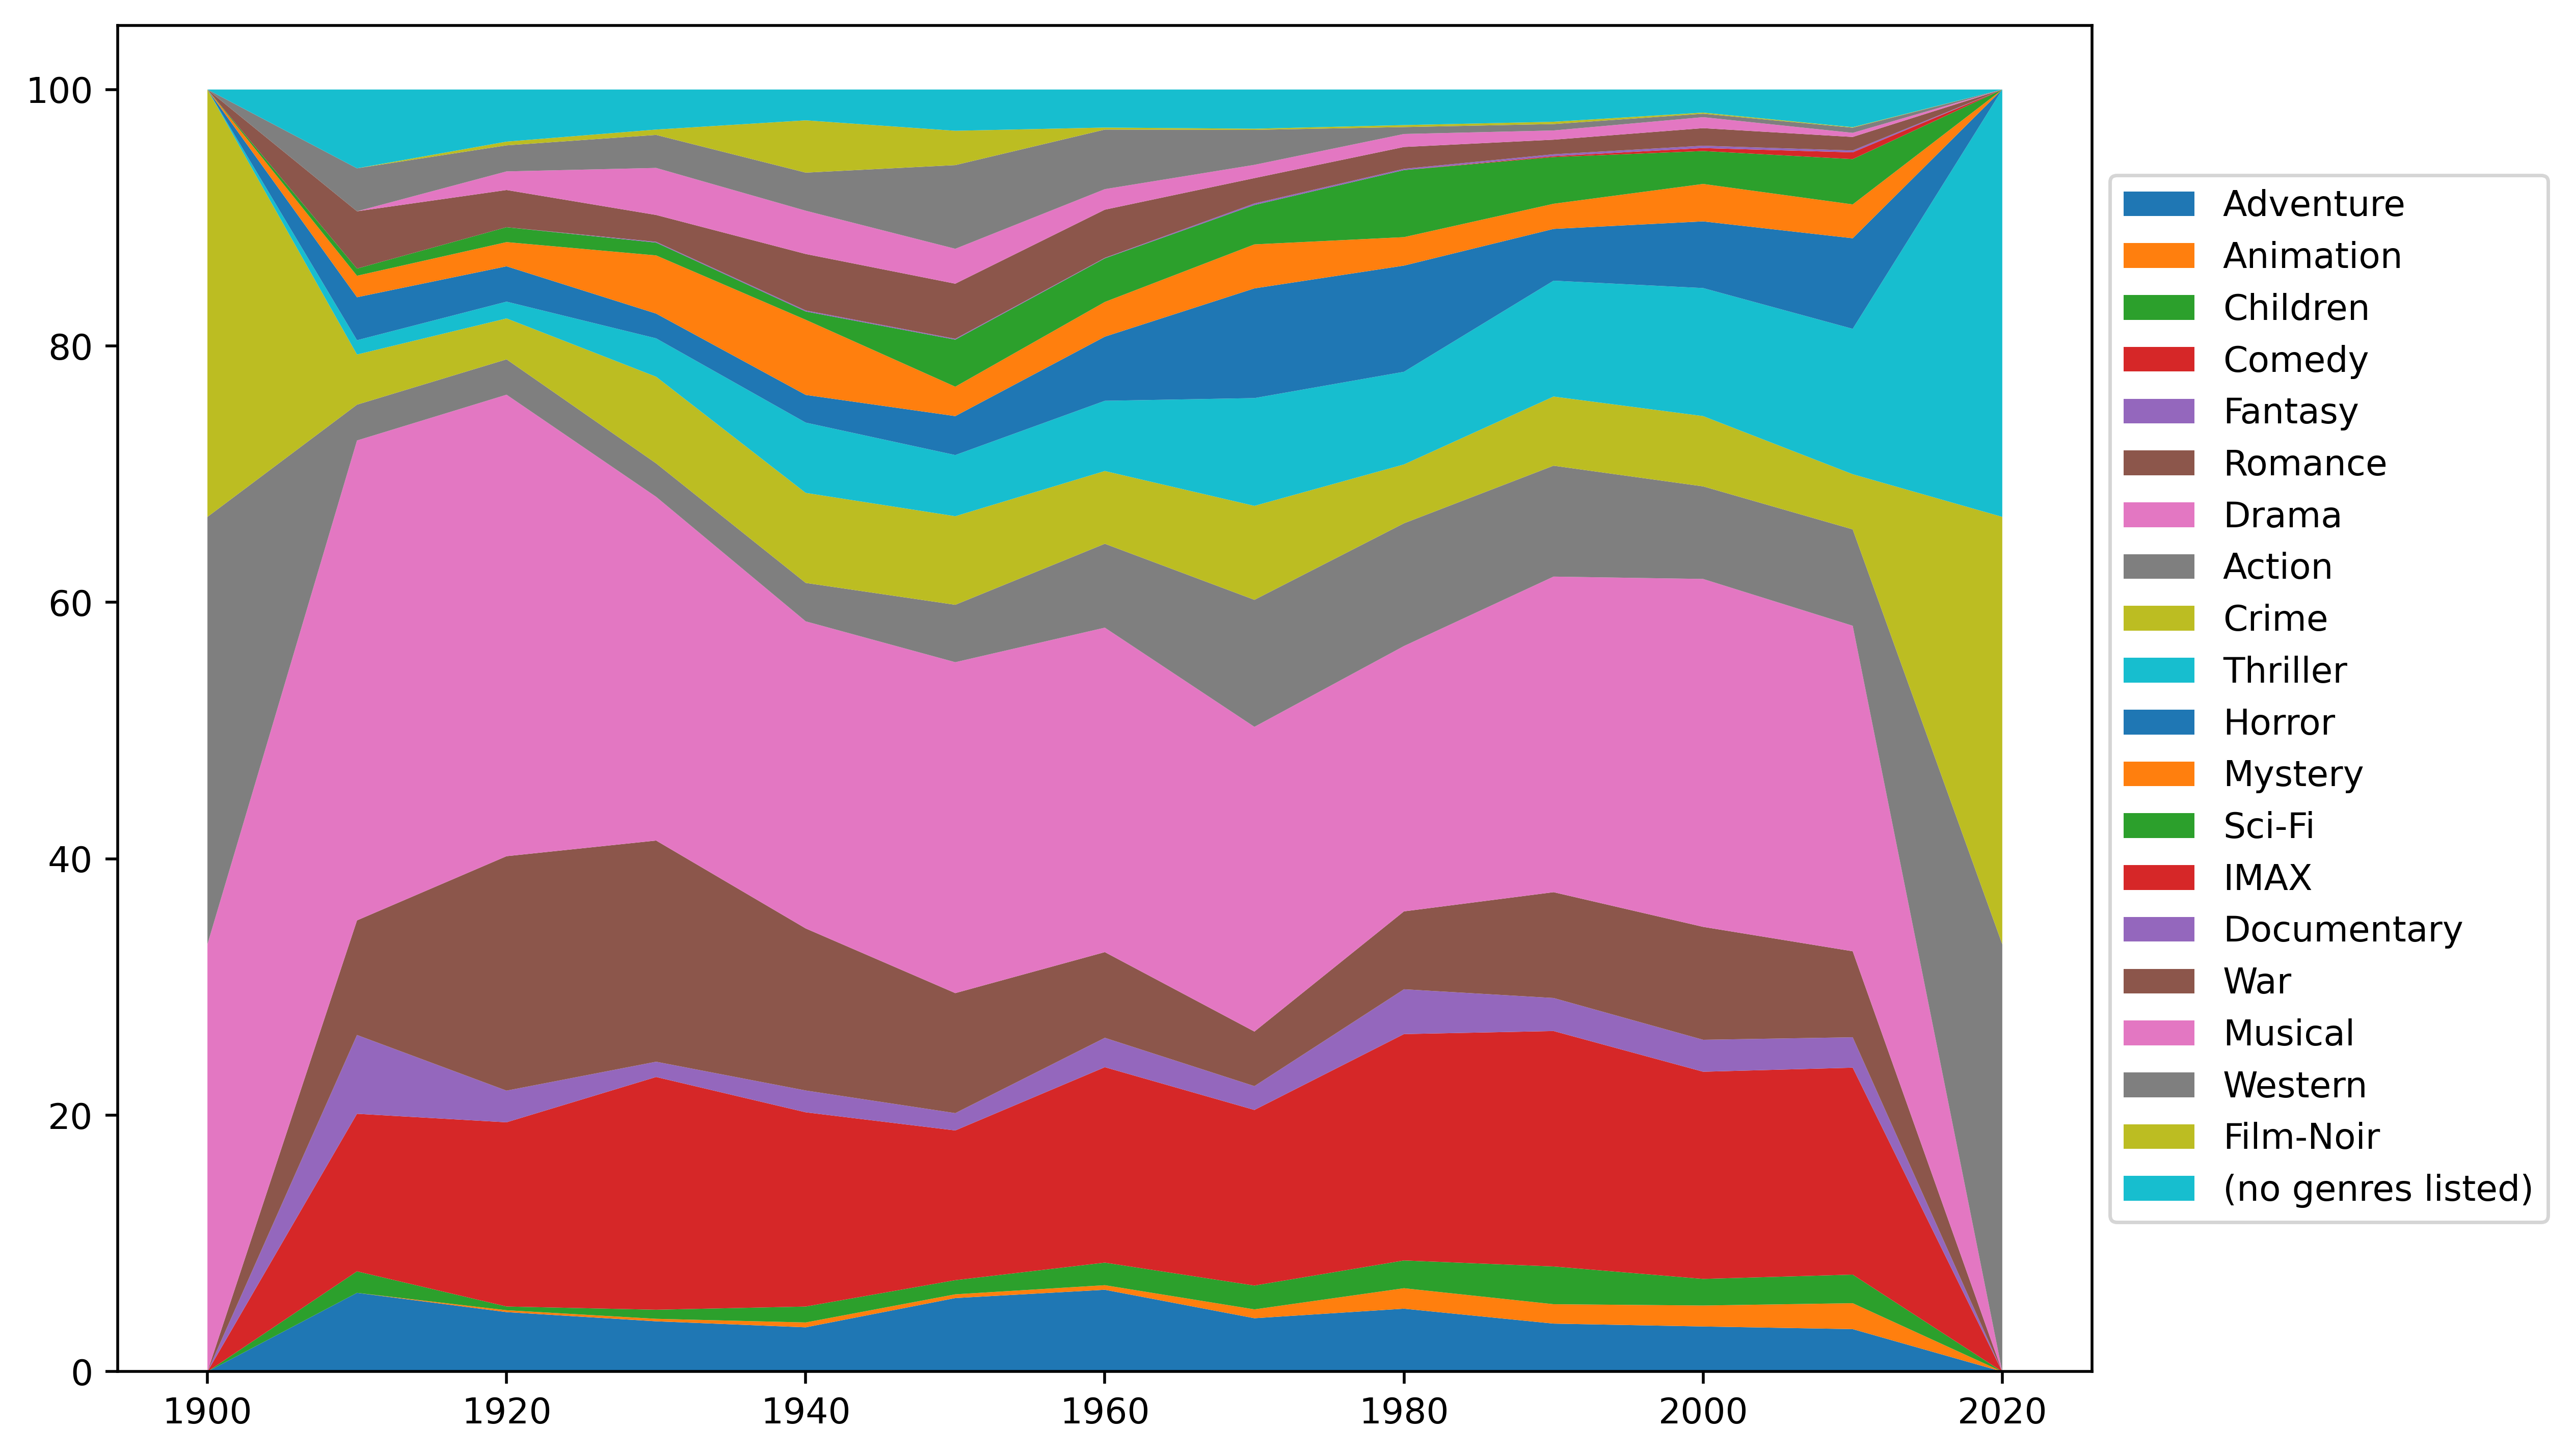

In [47]:
plt.subplots(figsize =(10, 7), dpi=500)

plt.stackplot(state_pcts.index, state_pcts.T ,labels=all_genres )

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

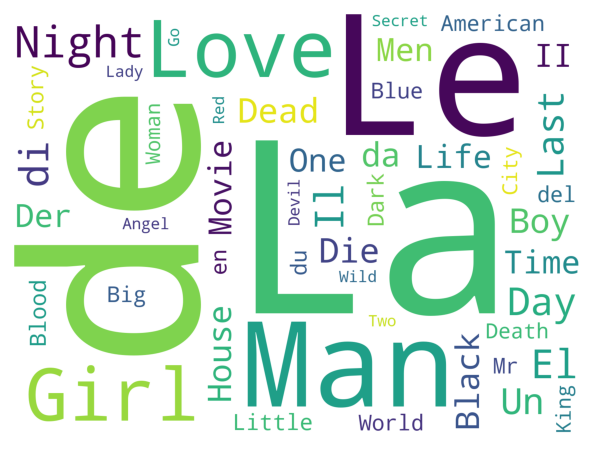

In [48]:
w=wc.WordCloud(background_color="white",margin=20,width=800,height=600,prefer_horizontal=0.7,max_words=50,scale=2)

w.generate(' '.join( Movies_metadata.original_title ))

f, ax = plt.subplots(figsize=(16, 8))
plt.axis('off')
plt.imshow(w)
plt.show()

## Rating

In [3]:
def ShowStatistics(ratings, label="df" ):
    return { label : pd.Series( [ ratings.shape[0], 
                                 f"( { np.min( ratings.groupby('rating').count().index )}, {np.max( ratings.groupby('rating').count().index )})", 
                                 ratings.groupby('movieId').count().shape[0], 
                                 ratings.groupby('userId').count().shape[0] ],
                       index =['rating','range', 'movies','users']) }

In [4]:
ratings = pd.read_csv(Dataset_path+"ratings_2004.csv")
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10521965 entries, 0 to 10521964
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 321.1 MB


In [5]:
ratings.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [6]:
# ratings01 = pd.merge(ratings, Movies_metadata[ 'movieId' ], how='inner')
# pd.DataFrame( ShowStatistics(ratings, 'before') | ShowStatistics(ratings01, 'after') )

ratings02 = ratings

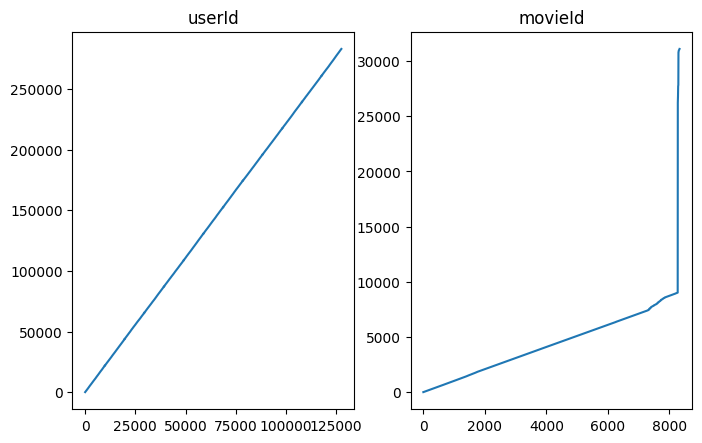

In [7]:
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

plt.subplots(figsize =(8,5), dpi=100)

y = np.sort( ratings02['userId'].unique() )
plt.subplot(1, 2, 1)
plt.plot( y )
plt.title("userId")

x = np.sort( ratings02['movieId'].unique() )
plt.subplot(1, 2, 2)
plt.plot( x )
plt.title("movieId")


plt.show()

### Ratings Distribution

In [8]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

data = ratings02['rating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / ratings02.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} movie-ratings'.format(ratings02.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

### Ratings Distribution By movie

In [16]:
# Number of ratings per Movie
data = ratings02.groupby('movieId')['rating'].count().clip(upper=70000)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 500,
                                  size = 10))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per movie',
                   xaxis = dict(title = 'Number of Ratings Per movie'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [10]:
ratings02.groupby('movieId')['rating'].count().reset_index().sort_values('rating', ascending=False)[:10]

movieId  rating
293      296   43706
587      593   43476
352      356   42988
476      480   41576
453      457   38821
586      592   37995
584      590   37889
148      150   37190
108      110   36260
315      318   36178

### Ratings Distribution By User

In [11]:
# Number of ratings per user
data = ratings02.groupby('userId')['rating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per User (Clipped at 50)',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [12]:
ratings02.groupby('userId')['rating'].count().reset_index().sort_values('rating', ascending=False)[:10]

userId  rating
53000   117490    5533
82564   183233    5169
71145   158002    3555
28697    63783    3399
28873    64180    3187
23087    51571    3027
105622  234257    2790
60045   133398    2740
2148      4796    2727
27722    61614    2727